<img src="https://skillvertex.in/wp-content/uploads/2022/07/Skill-Vertex-Logo_PNG.png" alt="alt text" title="image Title" height="50"/>

Submitted By: 

> Richard Honey

> Keerti

<h1><center>Employee Promotion Prediction</center></h1>

`Group Project`

<h3><center>Predicting whether an employee is promoted or not based on various factors</center></h3>

The aim is to analyze the various factors that can contribute to the promotion of an employee. Based on the analysis, predict which employees will be promoted.<br>

The following details for an employee is given in the dataset :-
    
   * Department - department of the employee
   * Region - region as designated by the company
   * Education - qualification of the employee
   * Gender - gender of the employee
   * Recruitment channel - means via which employee was recruited
   * No of trainings - total number of trainings undergone by the employee
   * Age - age of the employee
   * Previous year ratings - previous year performance ratings of the employee
   * Length of service - total years worked for the company
   * KPIs met(1 if >80%) - total KPIs met in the tenure
   * Average training score - average score on trainings
   * Awards won - Awards won if any
   
The target column is the *is_promoted* column. The column is binary and specifies whether the employee was promoted or not.

In [55]:
# Libraries to import
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [8]:
df = pd.read_csv('Promotion.csv')

## Data Structure

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [11]:
df.shape

(54808, 14)

## Data Pre-Processing

In [10]:
cols = ['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met', 'awards_won',
       'avg_training_score', 'is_promoted']
df.columns = cols

In [12]:
df.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met                   0
awards_won                 0
avg_training_score         0
is_promoted                0
dtype: int64

A new employee joining in the current year would not have a *previous_year_rating*. Thus, *previous_year_rating* contains 4224 null values. *Previous_year_rating* which are Null are compared to the *length_of_service* column gives the number of years employee has now worked for the company. The *length of service* has the minimum value of 1, this implies that any new joinee is also by default said to have worked for the company for one year.

### Treating null values

#### Treating null values in *previous_year_rating*

In [14]:
df.previous_year_rating.value_counts(dropna=False)

3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
NaN     4124
Name: previous_year_rating, dtype: int64

In [15]:
service_filter = df[df.length_of_service == 1]
print(
    "Null rating counts of employees with length of service 1\n",
    service_filter.previous_year_rating.isnull().sum()
)
print(
    "Null rating counts of employees with length of service 1 and promoted\n",
    service_filter[service_filter.is_promoted == 1].previous_year_rating.isnull().sum()
)
df.previous_year_rating = df.previous_year_rating.fillna(0)

Null rating counts of employees with length of service 1
 4124
Null rating counts of employees with length of service 1 and promoted
 339


#### Treating null values in *education*

In [16]:
df[df.education.isna()].is_promoted.value_counts()

0    2287
1     122
Name: is_promoted, dtype: int64

One solution to impute the education column is to fill the Null values with the mode of the column. The mode of the column gives the qualification that is most frequent among the employees.

In [17]:
depts = df.department.unique()

for dept in depts:
    edu = df[df.department == dept].education.mode()[0]
    print(dept," : ",edu)
    

Sales & Marketing  :  Bachelor's
Operations  :  Bachelor's
Technology  :  Bachelor's
Analytics  :  Bachelor's
R&D  :  Bachelor's
Procurement  :  Bachelor's
Finance  :  Bachelor's
HR  :  Bachelor's
Legal  :  Bachelor's


In [19]:
df.education = df.education.fillna(df.education.mode()[0])

#### Checking if all the null vales are cleaned

In [20]:
df.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met                0
awards_won              0
avg_training_score      0
is_promoted             0
dtype: int64

#### Number of Unique values

In [23]:
df.nunique()

employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        6
length_of_service          35
KPIs_met                    2
awards_won                  2
avg_training_score         61
is_promoted                 2
dtype: int64

## EDA

### Univariate Analysis

In [13]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met,awards_won,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


#### Percentage of people who got promoted from each department

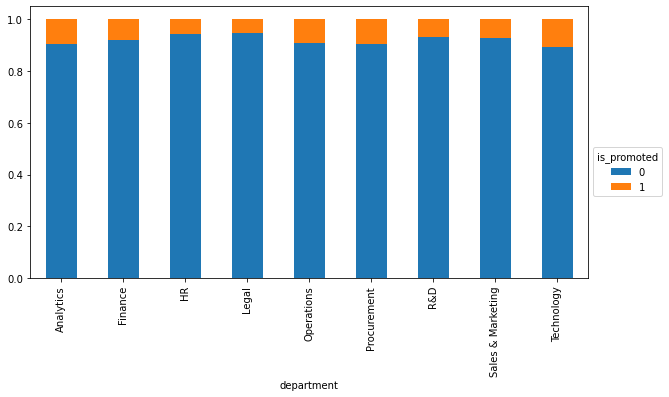

In [25]:
plt.rcParams['figure.figsize'] = [10, 5]
ct = pd.crosstab(df.department,df.is_promoted,normalize='index')
ct.plot.bar(stacked=True)
plt.legend(title='is_promoted',bbox_to_anchor=(1,0.5))

While Technology department had highest percentage of employees getting promoted, Legal department has the least number. But we don't see major differences in terms of percentages.

#### Percentage of promotions across all the regions

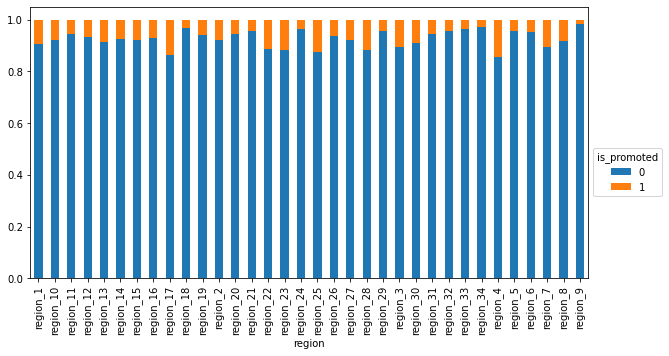

In [26]:
reg = pd.crosstab(df.region,df.is_promoted,normalize='index')
reg.plot.bar(stacked=True)
plt.legend(title='is_promoted',bbox_to_anchor=(1,0.5))

#### Distribution of promotions among people with different Educational backgrounds

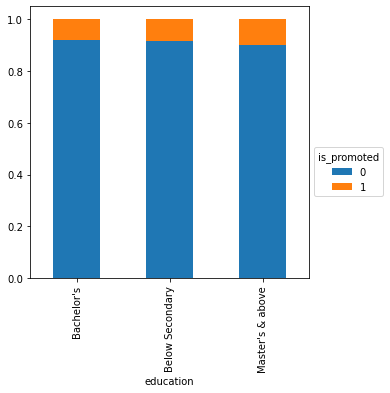

In [27]:
plt.rcParams['figure.figsize'] = [5, 5]
edu = pd.crosstab(df.education,df.is_promoted,normalize='index')
edu.plot.bar(stacked=True)
plt.rcParams['figure.figsize'] = [5, 5]
plt.legend(title='is_promoted',bbox_to_anchor=(1,0.5))

#### Variation of promotion percentage with respect to gender

In [28]:
pd.crosstab(df.gender,df.is_promoted,normalize='index')

is_promoted,0,1
gender,,
f,0.910066,0.089934
m,0.916849,0.083151


#### Difference in the percentage of promoted employees with respect to previous year ratings

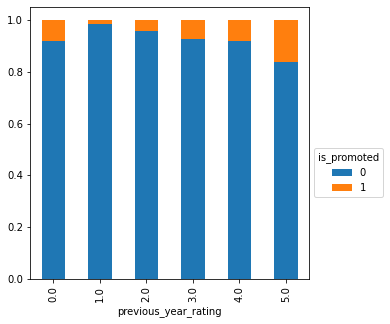

In [30]:
rating = pd.crosstab(df.previous_year_rating,df.is_promoted,normalize='index')
rating.plot.bar(stacked=True)
plt.legend(title='is_promoted',loc='upper left',bbox_to_anchor=(1, 0.5))

#### Genderwise Pie Chart Depicting Promoted and Not promoted Employees

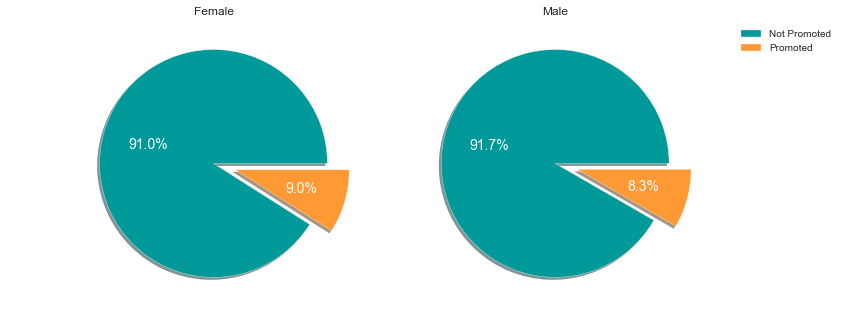

In [33]:
plt.style.use('seaborn')
plt.subplots(figsize=(10,6))
plt.subplot(1,2,1)
plt.pie(
    x=df[df.gender=='f'].is_promoted.value_counts(normalize=True),
    labels=['Not Promoted','Promoted'],
    explode=[0,0.2],
    autopct="%1.1f%%",
    shadow=True,
    textprops=dict(color='w',fontsize=14),
    colors=['#009999','#ff9933']
)
plt.title("Female")
plt.subplot(1,2,2)
plt.pie(
    x=df[df.gender=='m'].is_promoted.value_counts(normalize=True),
    labels=['Not Promoted','Promoted'],
    explode=[0,0.2],
    autopct="%1.1f%%",
    shadow=True,
    textprops=dict(color='w',fontsize=14),
    colors=['#009999','#ff9933']
)
plt.title("Male")
plt.legend(['Not Promoted','Promoted'],loc='upper right', bbox_to_anchor=(1, 0.5, 0.5, 0.5))

#### Promotion on the Basis of Length of Service

#### 

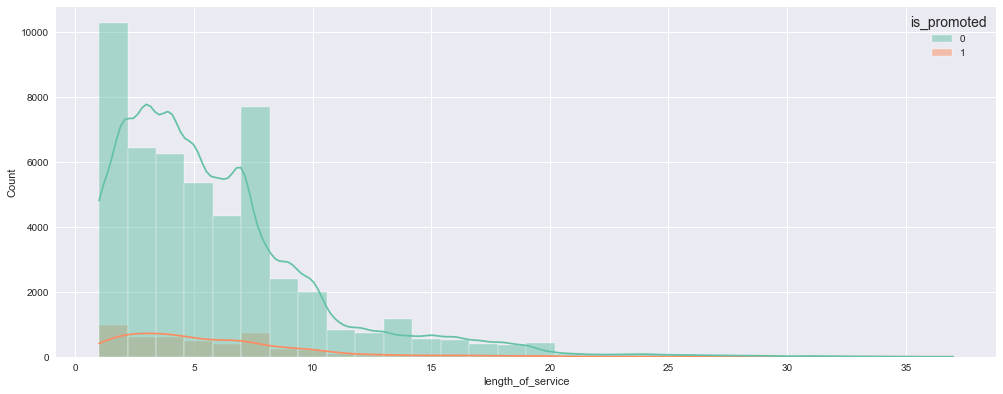

In [47]:
plt.figure(figsize=(15,6))
sns.histplot(x='length_of_service',hue='is_promoted',data=df,palette='Set2',bins=30,kde=True);

### Multivariate Analysis

#### Average Training Score

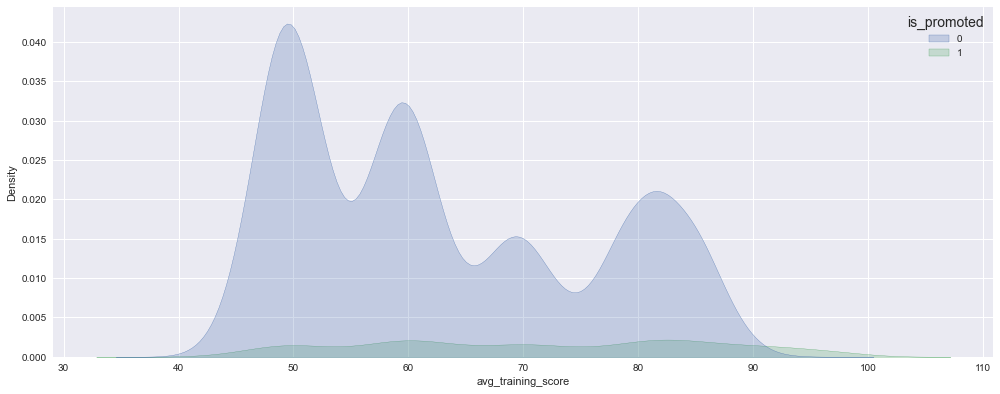

In [48]:
plt.figure(figsize=(15,6))
sns.kdeplot(x='avg_training_score',hue='is_promoted',data=df,shade=True);

#### Heatmap

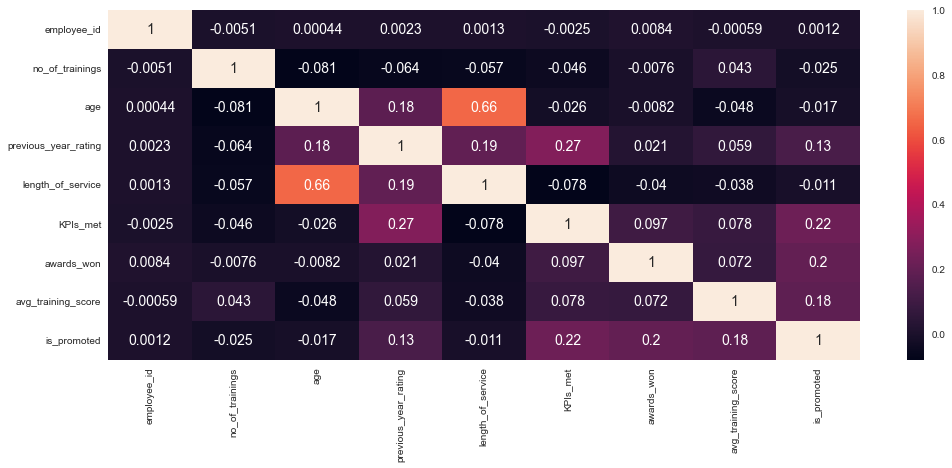

In [50]:
plt.figure(figsize=(15,6))
correlation = df.corr(method='pearson')
sns.heatmap(correlation,annot=True);

## Data Modelling

#### Data Pre-Processing

In [53]:
# Identify input and target columns
input_cols, target_col = df.columns[1:-1], df.columns[-1]
inputs_df, targets = df[input_cols].copy(), df[target_col].copy()

# Identify numeric and categorical columns
numeric_cols = df[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = df[input_cols].select_dtypes(include='object').columns.tolist()

# Impute and scale numeric columns
imputer = SimpleImputer().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = imputer.transform(inputs_df[numeric_cols])
scaler = MinMaxScaler().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])

#### One Hot Encode Categorical Columns

In [54]:
# One-hot encode categorical columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])

# Create training and validation sets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[numeric_cols + encoded_cols], targets, test_size=0.25, random_state=42)
import warnings
warnings.filterwarnings('ignore')

C:\Users\richa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Random Forest

In [56]:
rf = RandomForestClassifier(random_state=42)
rf.fit(train_inputs,train_targets)

RandomForestClassifier(random_state=42)

In [57]:
rf_train_score = rf.score(train_inputs,train_targets)
rf_val_score = rf.score(val_inputs,val_targets)
print('Random Forest Classifier Training Score: {}, Random Forest Classifier Validation score:{}'.format(rf_train_score,rf_val_score))

Random Forest Classifier Training Score: 0.9996837444655281, Random Forest Classifier Validation score:0.9360677273390746


In [58]:
val_targets.value_counts() / len(val_targets)

0    0.917457
1    0.082543
Name: is_promoted, dtype: float64

## Conclusion

Training Accuracy is close to 100% and validation accuracy is 2% better than always predicting "No". It appears that model is overfitting as training sets are perfectly understood by model. However for other than training sets model is not able to predict.  